Рассуждение, что модель можно улучшить

In [24]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader

from src import data, model, train, visualization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
train_data_path = './data/train_32x32.mat'
test_data_path = './data/test_32x32.mat'

Описание улучшения обучения, ссылка на статью

In [26]:
train_data = data.prepare_data(train_data_path)
split = int(0.8 * len(train_data))

train_loader = DataLoader(train_data[:split], batch_size=32, shuffle=False)
validation_loader = DataLoader(train_data[split:], batch_size=32, shuffle=False)

cnn_model = model.DropoutCNN(0.2)
loss_fn = torch.nn.CrossEntropyLoss()

torch.manual_seed(42)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.1, momentum=0.9)

checkpoint, history = train.train_model(cnn_model, train_loader, validation_loader, 5, loss_fn, optimizer, disable_logs=False)

  0%|          | 0/5 [00:00<?, ?it/s]

After epoch 0, avg training loss is 2.6282, avg validation loss is 2.7069, acc on train set is 9.74% and acc on validation set is 10.23%
After epoch 1, avg training loss is 2.6325, avg validation loss is 2.5883, acc on train set is 9.76% and acc on validation set is 10.18%
After epoch 2, avg training loss is 2.6356, avg validation loss is 2.5923, acc on train set is 9.88% and acc on validation set is 10.18%
After epoch 3, avg training loss is 2.6375, avg validation loss is 2.6361, acc on train set is 9.84% and acc on validation set is 10.18%
After epoch 4, avg training loss is 2.6358, avg validation loss is 2.6846, acc on train set is 9.92% and acc on validation set is 10.23%


Описание моего разочарования

In [28]:
train_loader = DataLoader(train_data[:split], batch_size=32, shuffle=False)
validation_loader = DataLoader(train_data[split:], batch_size=32, shuffle=False)

cnn_model = model.DropoutCNN(0.2)

torch.manual_seed(42)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

checkpoint, history = train.train_model(cnn_model, train_loader, validation_loader, 100, loss_fn, optimizer, disable_logs=True)

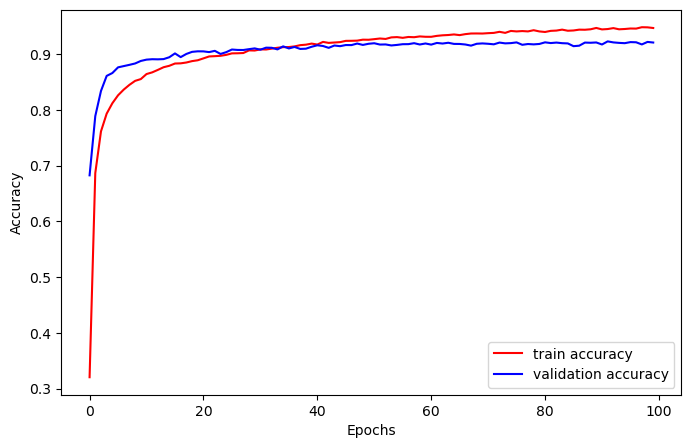

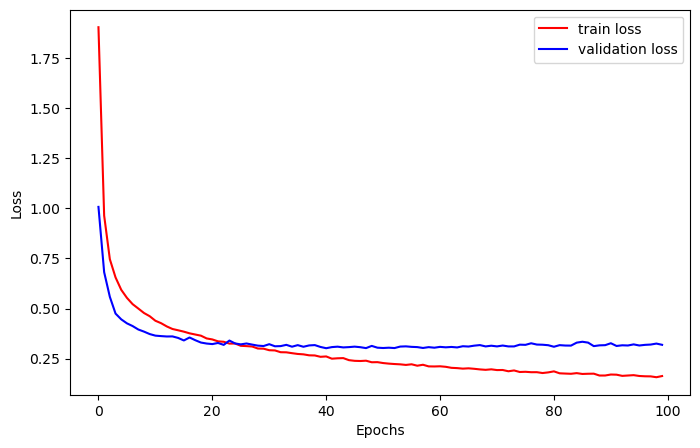

In [29]:
visualization.accuracy_plot(history['train_acc'], history['valid_acc'])
visualization.loss_plot(history['train_loss'], history['valid_loss'])

In [30]:
test_data = data.prepare_data(test_data_path)

test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

trained_model = model.DropoutCNN(0.2)
trained_model.load_state_dict(checkpoint['state_dict'])

test_acc, test_loss = train.step(trained_model, test_loader, loss_fn, _, test=True)
print(f'Test accuracy: {test_acc * 100:.4f}%, test loss: {test_loss:.4f}')

Test accuracy: 91.2100%, test loss: 0.3467


Описание теста без дропаута, ссылка на статью

In [91]:
train_loader = DataLoader(train_data[:split], batch_size=32, shuffle=False)
validation_loader = DataLoader(train_data[split:], batch_size=32, shuffle=False)

cnn_model = model.SOLDropoutCNN(0.2)

torch.manual_seed(42)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

checkpoint, history = train.train_model(cnn_model, train_loader, validation_loader, 100, loss_fn, optimizer, disable_logs=True)

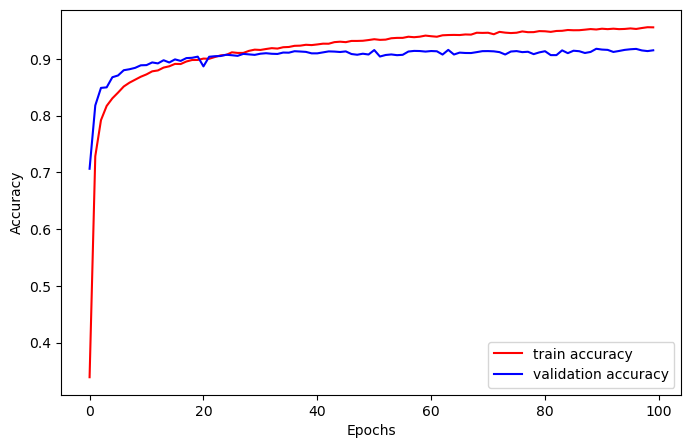

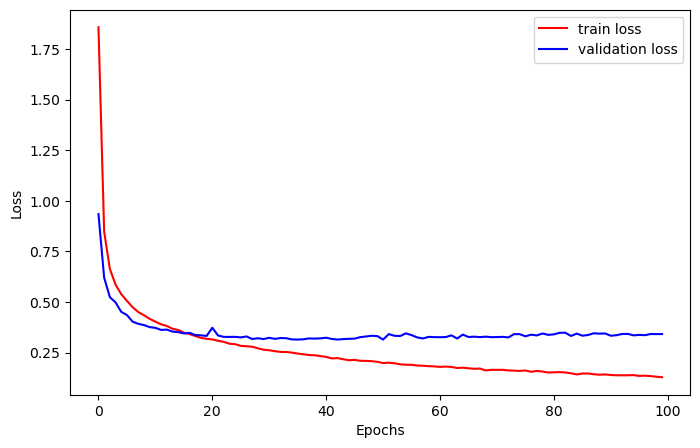

In [92]:
visualization.accuracy_plot(history['train_acc'], history['valid_acc'])
visualization.loss_plot(history['train_loss'], history['valid_loss'])

In [93]:
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

trained_model = model.SOLDropoutCNN(0.2)
trained_model.load_state_dict(checkpoint['state_dict'])

test_acc, test_loss = train.step(trained_model, test_loader, loss_fn, _, test=True)
print(f'Test accuracy: {test_acc * 100:.4f}%, test loss: {test_loss:.4f}')

Test accuracy: 91.0282%, test loss: 0.3654


Описание бетонного дропаута, ссылка на статью

In [133]:
train_loader = DataLoader(train_data[:split], batch_size=32, shuffle=False)
validation_loader = DataLoader(train_data[split:], batch_size=32, shuffle=False)

cnn_model = model.ConcreteDropoutCNN()

torch.manual_seed(42)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

In [134]:
checkpoint, history = train.train_model_with_sampling(cnn_model, train_loader, validation_loader, 10, loss_fn, optimizer, 10, t=1, disable_logs=False)

  0%|          | 0/10 [00:00<?, ?it/s]

After epoch 0, avg training loss is 1.7328, avg validation loss is 1.0056, acc on train set is 39.47% and acc on validation set is 67.43%
tensor([0.1725]) tensor([0.1633]) tensor([0.2124]) tensor([0.1736])
After epoch 1, avg training loss is 0.7724, avg validation loss is 0.6771, acc on train set is 75.67% and acc on validation set is 78.90%
tensor([0.1377]) tensor([0.1123]) tensor([0.1481]) tensor([0.1408])
After epoch 2, avg training loss is 0.5863, avg validation loss is 0.5745, acc on train set is 81.89% and acc on validation set is 82.27%
tensor([0.1201]) tensor([0.0885]) tensor([0.1078]) tensor([0.1204])
After epoch 3, avg training loss is 0.4931, avg validation loss is 0.5051, acc on train set is 84.77% and acc on validation set is 84.57%
tensor([0.1072]) tensor([0.0726]) tensor([0.0816]) tensor([0.1066])
After epoch 4, avg training loss is 0.4337, avg validation loss is 0.4683, acc on train set is 86.71% and acc on validation set is 86.33%
tensor([0.0970]) tensor([0.0612]) tens

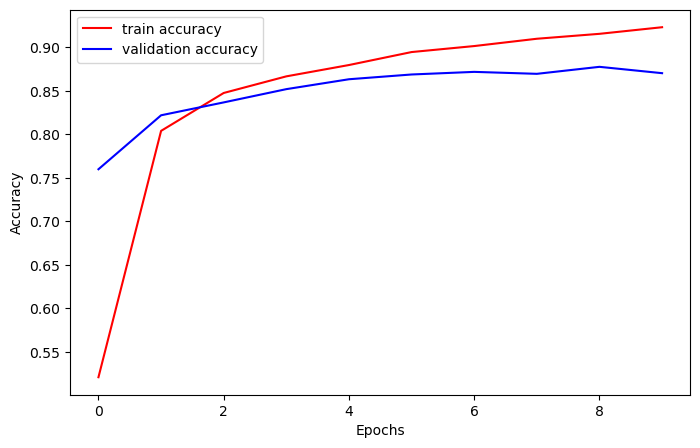

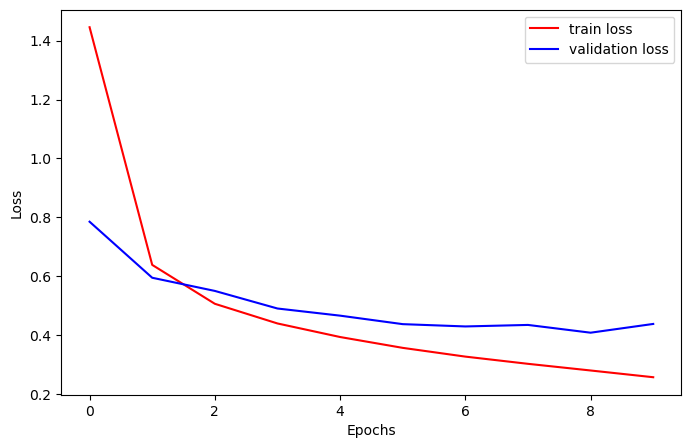

In [96]:
visualization.accuracy_plot(history['train_acc'], history['valid_acc'])
visualization.loss_plot(history['train_loss'], history['valid_loss'])

In [87]:
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

trained_model = model.ConcreteDropoutCNN()
trained_model.load_state_dict(checkpoint['state_dict'])

test_acc, test_loss = train.test_with_sampling(trained_model, test_loader, loss_fn, 10, t=1)
print(f'Test accuracy: {test_acc * 100:.4f}%, test loss: {test_loss:.4f}')

Test accuracy: 86.2884%, test loss: 0.4998


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


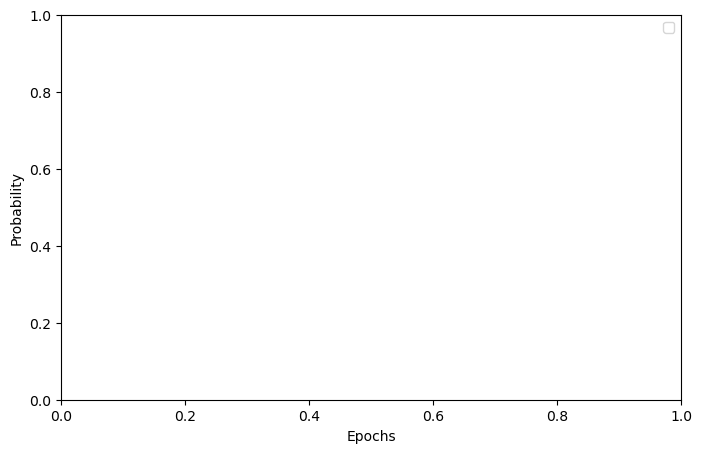

In [135]:
import matplotlib.pyplot as plt
import numpy as np

probability_changes = np.array(history['probs']).T

colors = ['b', 'g', 'r', 'c']

plt.figure(figsize=(8, 5))
for i, layer_prob in enumerate(probability_changes):
    plt.plot(
        layer_prob, color=colors[i], linestyle='dashed',
        label='Dropout probability ' + str(i + 1)
    )

plt.xlabel('Epochs')
plt.ylabel('Probability')
plt.legend()

In [136]:
history['probs']

[[], [], [], [], [], [], [], [], [], []]